In [1]:
import ast
# import import_ipynb
# import Extract_Python_Pairs as EPP
# #https://docs.python.org/3/library/tokenize.html
import tokenize
import io

import sqlite3 #database
import os #general
import time #general
from tqdm import tqdm #inline progress bar (quality of life)



import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#returns all the rows of the databse as a triplit (filename, code, comment)
def get_all_data():
    #start timer
    start = time.time()
    
    #connect to database
#     pwd = os.getcwd()
    print(os.getcwd())
    db_file = '../code_and_comments/all_data.db'
    
    conn = sqlite3.connect(db_file)
    
    #get all the rows from the databse
    cur = conn.cursor()
    cur.execute("SELECT * FROM all_data")
    rows = cur.fetchall()
    
    #wrapp it up
    conn.close()
    end = time.time()
    print("Completed in %d seconds" % (end - start))
    
    return rows

#rows = get_all_data()

In [3]:
#example of how ot iterate through the rows and getting info
'''
for row in rows[:10]:
    filename = row[0]
    code = row[1]
    comment = row[2]
'''

'\nfor row in rows[:10]:\n    filename = row[0]\n    code = row[1]\n    comment = row[2]\n'

In [4]:
#takes a dictionary and item for the purpose of counting number of items of that type
def dic_count(dic, item):
    if item in dic:
        dic[item] = dic[item]+1
    else:
        dic[item] = 1
    return dic
    
#returns the number of each extention in database
def get_extention_stats(rows):
    extention_count={}
    for row in tqdm(rows):
        filename = row[0]
        extention = filename.split('.')[-1]
        extention_count=dic_count(extention_count,extention)

    print(extention_count)

    
def get_python_pairs(rows):
    code_snippets = []
    comments = []
    too_big = 0
    for row in tqdm(rows):
        filename = row[0]
        extention = filename.split('.')[-1]
        if extention == 'py':
            #limit the size
            if len(row[1])<1000 and len(row[2])<1000:
                code_snippets.append(row[1])
                comments.append(row[2])
            else:
                too_big+=1
    print('Total pairs:',len(comments))
    return code_snippets, comments


    print(extention_count)

#code_snippets, comments = get_python_pairs(rows)

In [5]:
#get the code and comment snippets from the Extract Python Pairs file
code_snippets, comments = get_python_pairs(get_all_data())

/home/des338/Workspace/NLP/PythonCommentGenerataor


  1%|          | 177118/16115540 [00:00<00:08, 1771059.24it/s]

Completed in 51 seconds


100%|██████████| 16115540/16115540 [00:07<00:00, 2028715.27it/s]

Total pairs: 2508330


# Configuration

In [6]:
BATCH_SIZE = 64
EPOCHS = 500
LSTM_NODES = 128 # 256
NUM_SENTENCES = 500 # 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100

# Data

In [7]:
len(code_snippets)

2508330

In [8]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []



count = 0
print(count)
for i in range(len(code_snippets)):
    
    count += 1

    if count > NUM_SENTENCES:
        break
        

    input_sentence = code_snippets[i]
    output = comments[i]
    
    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output
    

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)
    
    
    

print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))
print(input_sentences[172])
print(output_sentences[172])
print(output_sentences_inputs[172])

0
num samples input: 500
num samples output: 500
num samples output input: 500
  def testNoEnvVarNoFlag(self):
    

    if not IS_WINDOWS:
      self.assert_(not UsesColor('dumb', None, None))
      self.assert_(not UsesColor('emacs', None, None))
      self.assert_(not UsesColor('xterm-mono', None, None))
      self.assert_(not UsesColor('unknown', None, None))
      self.assert_(not UsesColor(None, None, None))
    self.assert_(UsesColor('linux', None, None))
    self.assert_(UsesColor('cygwin', None, None))
    self.assert_(UsesColor('xterm', None, None))
    self.assert_(UsesColor('xterm-color', None, None))
    self.assert_(UsesColor('xterm-256color', None, None))


Tests the case when there's neither GTEST_COLOR nor --gtest_color. <eos>
<sos> Tests the case when there's neither GTEST_COLOR nor --gtest_color.


# Tokenization

In [9]:
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 1982
Length of longest sentence in input: 148


In [10]:
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 2356
Length of longest sentence in the output: 113


# Padding

In [11]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])
# print(word2idx_inputs["i'm"])
# print(word2idx_inputs["ill"])

encoder_input_sequences.shape: (500, 148)
encoder_input_sequences[172]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    2 1523    1    4   12   14  574    1   26   12  114
  309    9    9    1   26   12  114 1048    9    9    1   26   12  114
  373 1524    9    9    1   26   12  114  498    9    9    1   26   12
  114    9    9    9    1   26  114 1525    9    9    1   26  114 1526
    9    9    1   26  114  446    9    9    1   26  114  373  447    9
    9    1   26  114  373 1527    9    9]


In [12]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", decoder_input_sequences[172])
# print(word2idx_outputs["<sos>"])
# print(word2idx_outputs["je"])
# print(word2idx_outputs["suis"])
# print(word2idx_outputs["malade."])

decoder_input_sequences.shape: (500, 113)
decoder_input_sequences[172]: [  4  20   1  63  38 419 643 420 644 310   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]


# Embeddings

In [13]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open("../glove.6B.100d.txt", encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [14]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
# print(embeddings_dictionary["ill"])
# print(embedding_matrix[539])

In [15]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

# Model

In [16]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)
decoder_targets_one_hot.shape

(500, 113, 2357)

In [17]:
for i, d in enumerate(decoder_input_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [18]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [19]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [20]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [21]:
model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

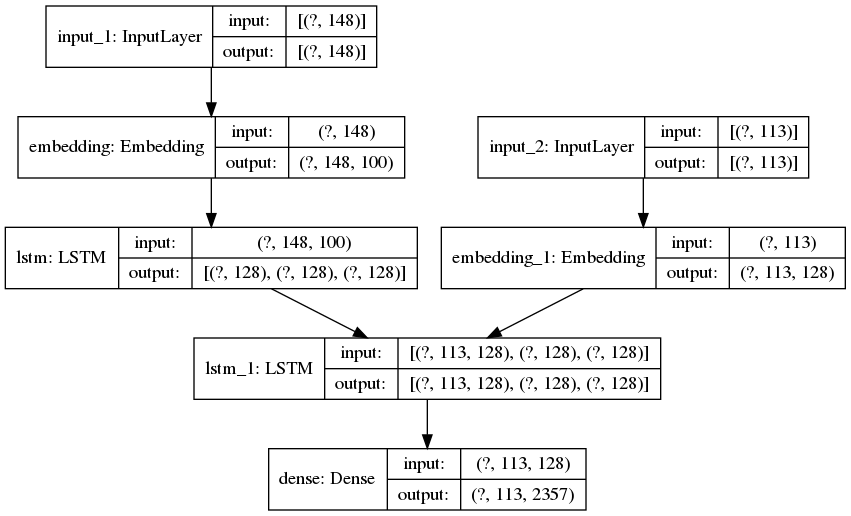

In [22]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

# Train

In [23]:
r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
)

Epoch 1/500
7/7 [==============================] - 1s 162ms/step - loss: 6.5018 - accuracy: 0.7233 - val_loss: 3.6535 - val_accuracy: 0.8278
Epoch 2/500
7/7 [==============================] - 0s 57ms/step - loss: 2.5593 - accuracy: 0.8599 - val_loss: 1.8075 - val_accuracy: 0.8366
Epoch 3/500
7/7 [==============================] - 0s 57ms/step - loss: 1.4412 - accuracy: 0.8638 - val_loss: 1.5093 - val_accuracy: 0.8366
Epoch 4/500
7/7 [==============================] - 0s 57ms/step - loss: 1.2400 - accuracy: 0.8638 - val_loss: 1.4324 - val_accuracy: 0.8366
Epoch 5/500
7/7 [==============================] - 0s 58ms/step - loss: 1.1668 - accuracy: 0.8638 - val_loss: 1.3773 - val_accuracy: 0.8366
Epoch 6/500
7/7 [==============================] - 0s 57ms/step - loss: 1.1099 - accuracy: 0.8638 - val_loss: 1.3389 - val_accuracy: 0.8366
Epoch 7/500
7/7 [==============================] - 0s 59ms/step - loss: 1.0684 - accuracy: 0.8638 - val_loss: 1.2299 - val_accuracy: 0.8366
Epoch 8/500
7/7 [==

In [24]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

from keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [25]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [27]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input:   def _signal_handler(self, signal, frame):
    
    if self.last_query_handle is None or self.query_handle_closed:
      return
    # Create a new connection to the impalad and cancel the query.
    try:
      self.query_handle_closed = True
      print_to_stderr(ImpalaShell.CANCELLATION_MESSAGE)
      new_imp_client = ImpalaClient(self.impalad)
      new_imp_client.connect()
      new_imp_client.cancel_query(self.last_query_handle, False)
      self.imp_client.close_query(self.last_query_handle)
      self._validate_database()
    except Exception, e:
      print_to_stderr("Failed to reconnect and close: %s" % str(e))
      # TODO: Add a retry here


Response: <sos> <sos> <sos> validate validate validate validate validate validate validate validate validate validate validate validate for
upper for
upper for
upper for
upper for
upper for
upper for
upper for
upper for
upper for
upper for
upper for
upper for
upper for
upper for
upper for
upper for
upper for
upper for
upper for
